# 验证 $$\frac{dS_1}{d \eta} + \frac{dS_2}{d \eta} + \frac{dS_3}{d \eta} = \frac{dS_{total}}{d \eta} $$

In [1]:
import numpy as np
# import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.integrate import simpson, trapezoid
# from IPython.display import Image

import mplhep as hep
hep.style.use('ATLAS')

import os
# from tqdm import tqdm
# import h5py
from concurrent.futures import ProcessPoolExecutor, as_completed


In [2]:
class EntropyAndDSdEtaCalculator:
    def __init__(self, eta=6.9, slices=121, y_0=3.78, sigma=0.6, 
                 eta_flat=1.5, eta_gw=1.3, y_loss=0.5, 
                 P_factor=1, L_factor=1, R_factor=1, alpha=2.0, beta=0.5):
        self.eta = eta
        self.slices = slices
        self.y_0 = y_0
        self.sigma = sigma
        self.L_factor = L_factor
        self.R_factor = R_factor
        self.P_factor = P_factor
        self.alpha = alpha
        self.beta = beta
        self.eta_flat = eta_flat
        self.eta_gw = eta_gw
        self.y_loss = y_loss

        self.coef_L, self.coef_R, self.coef_LR = self.calculate_coefficients()

    def gaussian(self, x=0, center=0, width=1):
        """
        Define a Gaussian distribution function.

        Parameters:
        x: Independent variable (single value or array)
        center: Center of the Gaussian
        width: Standard deviation of the Gaussian

        Returns:
        Gaussian value(s) at x
        """
        return np.exp(-((x - center) ** 2) / (2 * width ** 2))

    def plateau_function(self, eta):
        """
        Define a function with a plateau distribution.

        Parameters:
        eta: Independent variable array

        Returns:
        Plateau distribution values
        """
        # 初始化函数值，全为1
        heta = np.ones_like(eta)
        
        # 找到进入衰减区域的位置
        fall_off = np.abs(eta) > self.eta_flat
        
        # 对进入衰减区域的eta值计算其衰减部分
        eta_fall = np.abs(eta[fall_off])
        heta[fall_off] = np.exp(-(eta_fall - self.eta_flat) ** 2 / (2.0 * self.eta_gw ** 2))
        
        return heta

    def calculate_coefficients(self):
        """
        Calculate and return the longitudinal distribution coefficients for L, R, and LR.
        """
        etas = np.linspace(-self.eta, self.eta, self.slices)
        coef_l = self.L_factor * self.gaussian(x=etas, center=self.y_0 - self.y_loss, width=self.sigma)
        coef_r = self.R_factor * self.gaussian(x=etas, center=-self.y_0, width=self.sigma)
        coef_lr = self.P_factor * self.plateau_function(etas)
        return coef_l, coef_r, coef_lr

    def calc_3D_entropy_part(self, entropy_2d, coef_list):
        """
        Calculate entropy 3D for a specific part
        Multiply a 2D matrix with a 1D coefficient list to produce a 3D matrix.
        """
        entropy_3d = np.zeros((len(coef_list), *entropy_2d.shape))
        for i, coef in enumerate(coef_list):
            entropy_3d[i] = entropy_2d * coef
        
        return entropy_3d

    def calc_entropy3D(self, entropy_200x200_L, entropy_200x200_R):
        """
        Calculate the sum of three 3D entropy distribution.
        """
        entropy2d_combined = entropy_200x200_L * entropy_200x200_R

        entropy_L = self.calc_3D_entropy_part(entropy_200x200_L ** self.alpha, self.coef_L)
        entropy_R = self.calc_3D_entropy_part(entropy_200x200_R ** self.alpha, self.coef_R)
        entropy_LR = self.calc_3D_entropy_part(entropy2d_combined ** self.beta, self.coef_LR)

        return entropy_L + entropy_R + entropy_LR

############################# 使用计算好的三个 entropy2D 计算dSdEta再求和计算总分布 ###################################    
    # 计算 d 或 Au 的各自的能量密度
    def calc_dSdEta_part(self, entropy_200x200, coef_list):
        """
        Multiply a 200x200 matrix with a 121-element list and return a 121x200x200 array.
        """
        dtau0 = 0.6
        dx = 0.16
        dy = 0.16
        deta = 0.115
        dtau = dtau0 * dx * dy * deta
        dSdEta_half = np.zeros(len(coef_list)) # shape(121,)
        
        for i, coef in enumerate(coef_list):
            dSdEta_half[i] = np.sum(entropy_200x200) * dtau * coef
        return dSdEta_half

    # 计算总能量密度分布  
    def calc_dSdEta1(self, entropy_200x200_L, entropy_200x200_R):
        """Calculate the combined entropy."""
        entropy2d_plat = entropy_200x200_L * entropy_200x200_R
      
        dSdEta_L  = self.calc_dSdEta_part(entropy_200x200_L**self.alpha, self.coef_L)
        dSdEta_R  = self.calc_dSdEta_part(entropy_200x200_R**self.alpha, self.coef_R)
        dSdEta_LR = self.calc_dSdEta_part(entropy2d_plat**self.beta, self.coef_LR)  # 添加平台区域
         
        dSdEta = dSdEta_L + dSdEta_R + dSdEta_LR
        return dSdEta

################################### 使用计算好的 entropy3D 计算dSdEta #############################################    
    def calc_dSdEta_slice(self, entropy3D):
        dtau0 = 0.6
        dx = 0.16
        dy = 0.16
        deta = 0.115
        dtau = dtau0 * dx * dy * deta

        dSdEta = np.zeros(self.slices)
        for i in range(self.slices):
            dSdEta[i] = np.sum(entropy3D[i]) * dtau
        return dSdEta

    def calc_dSdEta2(self, entropy_200x200_L, entropy_200x200_R):
        entropy3D = self.calc_entropy3D(entropy_200x200_L, entropy_200x200_R)
        return self.calc_dSdEta_slice(entropy3D)

    


### 按照第一种方法计算dSdEta

In [3]:
def calculate_event_dSdEta(event, input_dir, calculator):
    """计算单事件的 dSdEta 值"""
    projectile_file = os.path.join(input_dir, f'projectile_entropy_event_{event}.dat')
    target_file = os.path.join(input_dir, f'target_entropy_event_{event}.dat')
    
    if os.path.exists(projectile_file) and os.path.exists(target_file):
        # 读取数据
        sum_gaussian_L = np.loadtxt(projectile_file)
        sum_gaussian_R = np.loadtxt(target_file)
        
        # 计算 dSdEta
        # 按照第一种方法计算dSdEta
        dSdEta = calculator.calc_dSdEta1(sum_gaussian_L, sum_gaussian_R)
        return dSdEta
    else:
        print(f"Warning: Files for event {event} not found.")
        return None

In [4]:
def calc_plot_dSdEta_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                         eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300],
                         L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                         HWF_or_DWF='HWF', num_workers=4):
    """
    逐事件并行计算 dSdEta，将结果保存为数组，并绘图。
    
    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param m, n: 中心度范围
    :param y_0, sigma: 调节纵向能量沉积的参数
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param y_loss: 损失参数
    :param L_factor, R_factor, P_factor, alpha, beta: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF
    :param num_workers: 并行线程数量
    :param save_dir: 保存结果的目录
    """

    # 实例化计算器
    calculator = EntropyAndDSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
                                   y_0=y_0, sigma=sigma, y_loss=y_loss, alpha=alpha, beta=beta,
                                   L_factor=L_factor, R_factor=R_factor, P_factor=P_factor)

    # 输入文件路径
    disk_2T = 'MZ'
    input_dir = (f'/media/mengzhu/{disk_2T}/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')

    # 并行计算并保存结果
    dSdEta_event_all = []  # 用于保存 dSdEta 和事件序号

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(calculate_event_dSdEta, event, input_dir, calculator): event
                   for event in range(event_range[0], event_range[1])}

        for future in as_completed(futures):
            event = futures[future]
            try:
                dSdEta_result = future.result()
                if dSdEta_result is not None:
                    # 保存 dSdEta 和事件序号
                    dSdEta_event_all.append([dSdEta_result, event])
            except Exception as e:
                print(f"Error processing event {event}: {e}")

    # 转换为 NumPy 数组
    dSdEta_event_array = np.array(dSdEta_event_all, dtype=object)
    dSdEta_event_list = dSdEta_event_array[np.argsort(dSdEta_event_array[:, 1])]

    # 绘图
    plt.figure(figsize=(8, 6))
    eta_values = np.linspace(-eta, eta, slices)

    for dSdEta, event in dSdEta_event_list:
        plt.plot(eta_values, dSdEta, label=f'Event {event}', alpha=0.6)

    plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
    plt.ylabel(r'$\rm dS/d\eta$', fontsize=20, ha='center')
    plt.title(r'$\rm dS/d\eta$ Distribution'
              + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
                + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}, $\\rm \\Delta \\eta$={y_loss}', fontsize=20)
    plt.legend(fontsize=12, loc='upper right', ncol=1)
    plt.grid()
#     plt.tight_layout()
    return dSdEta_event_array


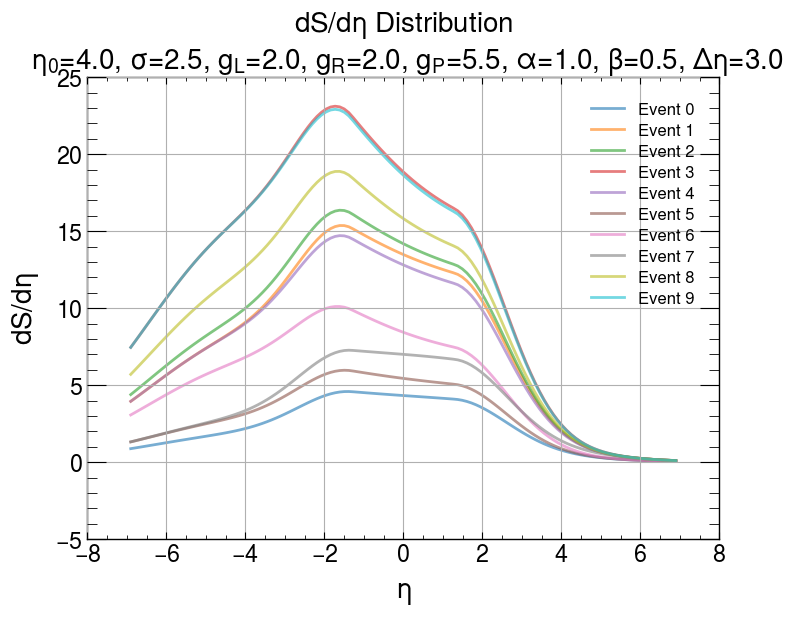

In [5]:
dSdEta_ebe = calc_plot_dSdEta_ebe(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                   eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 10],
                   L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                   HWF_or_DWF='DWF', num_workers=4)

In [6]:
dSdEta_ebe

array([[array([0.88218465, 0.93025986, 0.97898407, 1.02821086, 1.07779115,
               1.12757643, 1.17742257, 1.22719428, 1.2767702 , 1.32604872,
               1.37495436, 1.42344478, 1.4715182 , 1.51922112, 1.56665598,
               1.61398859, 1.66145475, 1.70936567, 1.75811149, 1.8081625 ,
               1.86006708, 1.914446  , 1.97198226, 2.03340612, 2.09947481,
               2.17094701, 2.24855215, 2.33295499, 2.42471654, 2.52425251,
               2.63179085, 2.74733066, 2.87060445, 3.00104635, 3.13776875,
               3.27954964, 3.42483261, 3.57174123, 3.71810857, 3.86152202,
               3.99938269, 4.1289778 , 4.24756339, 4.35245433, 4.44111736,
               4.51126318, 4.56093278, 4.58857378, 4.59310277, 4.57505978,
               4.55140058, 4.52798168, 4.50485261, 4.48204831, 4.45958952,
               4.43748339, 4.41572431, 4.39429489, 4.3731671 , 4.35230352,
               4.33165873, 4.31118074, 4.29081248, 4.27049329, 4.25016052,
               4.2297509 

### 按照积分值排序

In [7]:
def calculate_integral_simpson(dsdeta, etas):
    """计算 dsdeta 在 |etas| 范围 [3.0, 5.4] 内的积分值"""
    

    # 分别计算两个区间的积分
    mask1 = (etas >= -5.4) & (etas <= -3.0)
    mask2 = (etas >= 3.0) & (etas <= 5.4)

    # Simpson 方法
    ds_simpson1 = simpson(dsdeta[mask1], x=etas[mask1])
    ds_simpson2 = simpson(dsdeta[mask2], x=etas[mask2])
    
    integral = ds_simpson1 + ds_simpson2
    return integral

def calculate_integral_trapezoid(dsdeta, etas):
    """计算 dsdeta 在 |etas| 范围 [3.0, 5.4] 内的积分值"""
    
    # 分别计算两个区间的积分
    mask1 = (etas >= -5.4) & (etas <= -3.0)
    mask2 = (etas >= 3.0) & (etas <= 5.4)

    # Simpson 方法
    ds_trapezoid1 = trapezoid(dsdeta[mask1], etas[mask1])
    ds_trapezoid2 = trapezoid(dsdeta[mask2], etas[mask2])
    
    ds_total = ds_trapezoid1 + ds_trapezoid2
    return ds_total
def calculate_integral(dsdeta, etas, method="trapezoid"):
        """
        计算 |etas| 范围 [3.0, 5.4] 内的积分
        """
        mask1 = (etas >= -5.4) & (etas <= -3.0)
        mask2 = (etas >= 3.0) & (etas <= 5.4)
        if method == "trapezoid":
            integral_dS = trapezoid(dsdeta[mask1], etas[mask1]) + trapezoid(dsdeta[mask2], etas[mask2])
        elif method == "simpson":
            integral_dS = simpson(dsdeta[mask1], x=etas[mask1]) + simpson(dsdeta[mask2], x=etas[mask2])
        else:
            raise ValueError("Unsupported method: choose 'trapezoid' or 'simpson'")
        return integral_dS
    
def calc_plot_dSdEta_centrality_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                                    eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300],
                                    L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                                    HWF_or_DWF='HWF', num_workers=4, plot_dSdEta=True):
    """
    逐事件并行计算 dSdEta 和积分结果，将结果保存为数组，并绘图。
    
    返回值包含每个事件的 dSdEta, 事件序号，以及ds积分值。
    
    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向能量沉积的参数
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param y_loss: 损失参数
    :param L_factor, R_factor, P_factor, beta: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF
    :param num_workers: 并行线程数量
    """

    # 实例化计算器
    calculator = EntropyAndDSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
                                   y_0=y_0, sigma=sigma, y_loss=y_loss, alpha=alpha, beta=beta,
                                   L_factor=L_factor, R_factor=R_factor, P_factor=P_factor)

    # 输入文件路径
    disk_2T = 'MZ'
    input_dir = (f'/media/mengzhu/{disk_2T}/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')

    # 并行计算并保存结果
    dSdEta_event_all = []  # 用于保存 dSdEta、事件序号和积分值

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(calculate_event_dSdEta, event, input_dir, calculator): event
                   for event in range(event_range[0], event_range[1])}

        for future in as_completed(futures):
            event = futures[future]
            try:
                dSdEta_result = future.result()
                if dSdEta_result is not None:
                    # 计算积分
                    etas = np.linspace(-eta, eta, slices)
                    ds_total = calculate_integral(dSdEta_result, etas, method="trapezoid")
                    # 保存 dSdEta、事件序号和积分值
                    dSdEta_event_all.append([dSdEta_result, event, ds_total])
            except Exception as e:
                print(f"Error processing event {event}: {e}")

    # 转换为 NumPy 数组
    dSdEta_event_array = np.array(dSdEta_event_all, dtype=object)

    # 按积分值降序排序
    sorted_indices = np.argsort(dSdEta_event_array[:, 2])[::-1]
    dSdEta_event_array = dSdEta_event_array[sorted_indices]

    # 绘图
    if plot_dSdEta:
        plt.figure(figsize=(8, 6))
        eta_values = np.linspace(-eta, eta, slices)

        for dSdEta, event, dS in dSdEta_event_array:
            plt.plot(eta_values, dSdEta, label=f'Event {event} (dS ={dS:.2f})', alpha=0.6)

        plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
        plt.ylabel(r'$\rm dS/d\eta$', fontsize=20, ha='center')
        plt.title(r'$\rm dS/d\eta$ Distribution'
                  + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
                  + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}, $\\rm \\Delta \\eta$={y_loss}',fontsize=20)
        plt.legend(fontsize=12, loc='upper right', ncol=1)
        plt.grid()

    return dSdEta_event_array


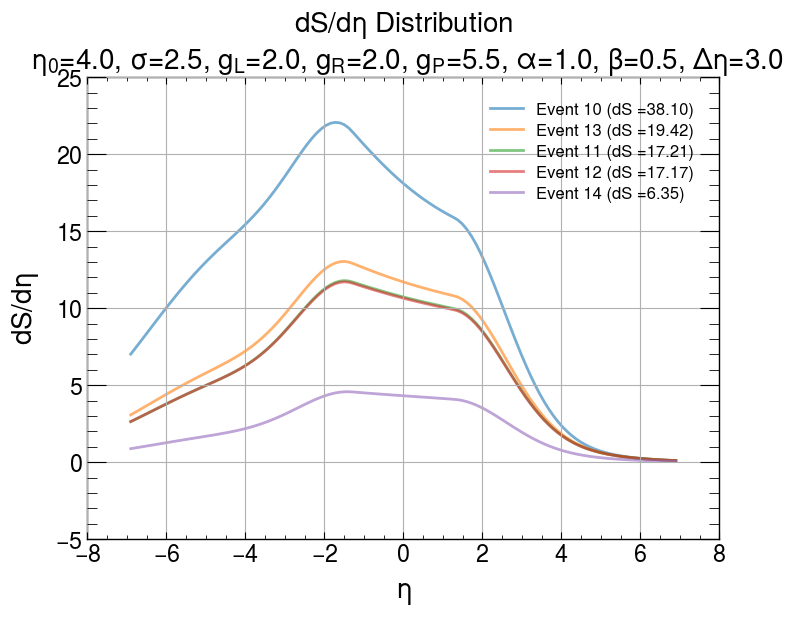

In [8]:
dSdEta_centrality_ebe = calc_plot_dSdEta_centrality_ebe(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                   eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[10, 15],
                   L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                   HWF_or_DWF='DWF', num_workers=4,plot_dSdEta=True)

### 按照第二种方法计算dSdEta

In [9]:
def calculate_event_dSdEta(event, input_dir, calculator):
    """计算单事件的 dSdEta 值"""
    projectile_file = os.path.join(input_dir, f'projectile_entropy_event_{event}.dat')
    target_file = os.path.join(input_dir, f'target_entropy_event_{event}.dat')
    
    if os.path.exists(projectile_file) and os.path.exists(target_file):
        # 读取数据
        sum_gaussian_L = np.loadtxt(projectile_file)
        sum_gaussian_R = np.loadtxt(target_file)
        
        # 计算 dSdEta
        # 按照第一种方法计算dSdEta
        dSdEta = calculator.calc_dSdEta2(sum_gaussian_L, sum_gaussian_R)
        return dSdEta
    else:
        print(f"Warning: Files for event {event} not found.")
        return None


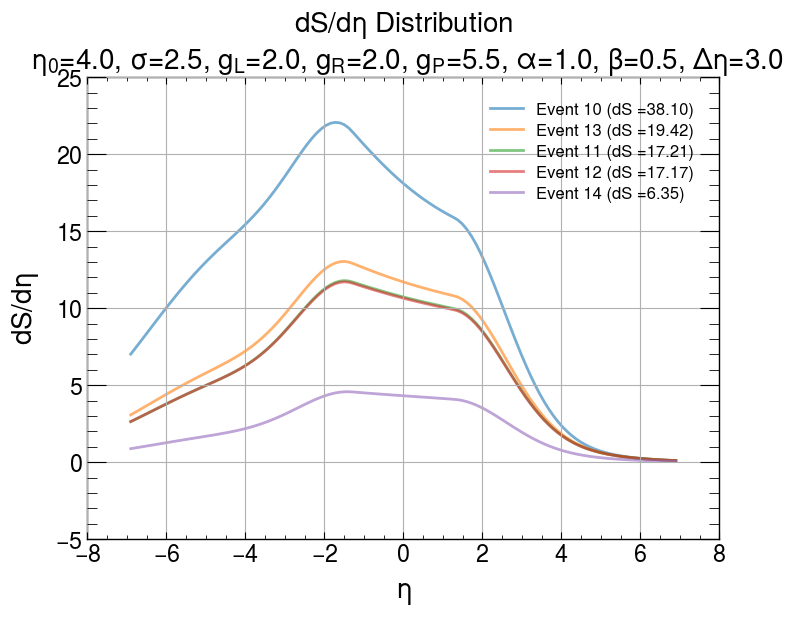

In [10]:
dSdEta_centrality_ebe = calc_plot_dSdEta_centrality_ebe(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                   eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[10, 15],
                   L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                   HWF_or_DWF='DWF', num_workers=4,plot_dSdEta=True)

# 上面的等式是成立的